In [3]:
!pip install fuzzy-c-means

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 107.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.1 MB/s eta 0:00:00
  Attempting uninstall: typer
    Found existing installation: typer 0.15.3
    Uninstalling typer-0.15.3:
      Successfully uninstalled typer-0.15.3
  Attempting uninstall: tabulate
    Found existing installation: tabulate 0.9.0
    Uninstalling tabulate-0.9.0:
      Successfully uninstalled tabulate-0.9.0
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
bigframes 2.1.0 requires tabulate>=0.

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, Birch
from fcmeans import FCM
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score, normalized_mutual_info_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import mixed_precision
import os
%matplotlib inline

In [8]:

gpus = tf.config.experimental.list_physical_devices('GPU')
for g in gpus:
    tf.config.experimental.set_memory_growth(g, False)

# Enable XLA (fuses kernels)
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=2'
tf.config.optimizer.set_jit(True)

# 2) Enable mixed-precision for Tensor Cores on the T4
mixed_precision.set_global_policy('mixed_float16')
print("Compute dtype:", mixed_precision.global_policy().compute_dtype)
print("Variable dtype:", mixed_precision.global_policy().variable_dtype)

print("GPUs available:", tf.config.list_physical_devices('GPU'))
!nvidia-smi                              # shows GPU status and memory


Compute dtype: float16
Variable dtype: float32
GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Wed May  7 18:16:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   54C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|         

In [9]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Path and parameters
CSV_PATH = '/content/drive/MyDrive/Cluster_4342/diabetes_data.csv'
PCA_DIMS = 2
N_CLUSTERS = 3

Mounted at /content/drive


In [13]:
# load data, detect label column, impute zeros, scale
def load_preprocess(path):
    df = pd.read_csv(path)
    label_col = df.columns[-1]
    y = df.pop(label_col).values
    for col in ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']:
        if col in df:
            df[col].replace(0, np.nan, inplace=True)
            df[col].fillna(df[col].median(), inplace=True)
    X = StandardScaler().fit_transform(df.values)
    return X, y, df.columns.tolist()

X, y_true, features = load_preprocess(CSV_PATH)
print('Data shape:', X.shape)

Data shape: (70692, 17)


<ipython-input-13-58172d949ca0>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].replace(0, np.nan, inplace=True)
<ipython-input-13-58172d949ca0>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.me

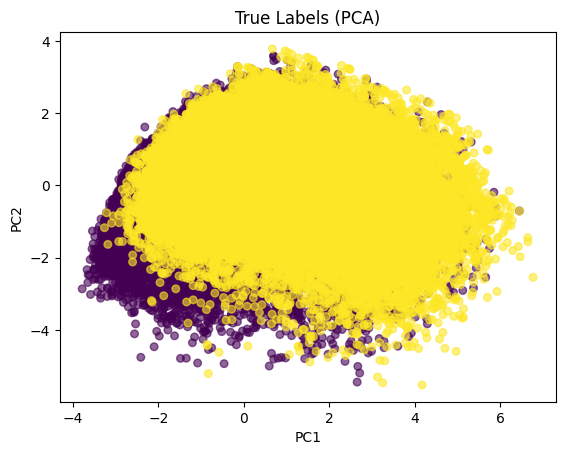

In [14]:
# PCA visualization
X_pca = PCA(n_components=PCA_DIMS).fit_transform(X)
plt.scatter(X_pca[:,0], X_pca[:,1], c=y_true, s=30, alpha=0.6)
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.title('True Labels (PCA)'); plt.show()
